In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# **Prelucrarea Datelor**

## Citirea datelor din fisierul pkl

Fisierul are urmatorul format:

* label
* signal
  * **chest**
    * ACC
    * ECG
    * EMG
    * EDA
    * Temp
    * Resp
  * **wrist**
    * ACC
    * BVP
    * EDA
    * TEMP




In [2]:
with open('WESAD/S2.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')

print("Data from chest:", data['signal']['chest'].keys())
print("Data from wrist:", data['signal']['wrist'].keys())

Data from chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
Data from wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [3]:
wrist_data = data['signal']['wrist']

acc_df = pd.DataFrame(wrist_data['ACC'], columns=['ACC_X', 'ACC_Y', 'ACC_Z'])
bvp_df = pd.DataFrame(wrist_data['BVP'], columns=['BVP'])
eda_df = pd.DataFrame(wrist_data['EDA'], columns=['EDA'])
temp_df = pd.DataFrame(wrist_data['TEMP'], columns=['TEMP'])

labels = data['label']

Datele **LABELS** au fost preluate cu o frecventa de ***700Hz***

In [4]:
print(labels.shape)
print(labels)

(4255300,)
[0 0 0 ... 0 0 0]


Datele **ACC** au fost preluate cu o frecventa de ***32Hz***

In [5]:
print(acc_df.shape)
print(acc_df.head())

(194528, 3)
   ACC_X  ACC_Y  ACC_Z
0   62.0  -21.0  107.0
1   66.0   13.0   53.0
2   41.0    9.0   15.0
3   52.0   16.0   24.0
4   54.0   15.0   34.0


Datele **BVP** au fost preluate cu o frecventa de ***64Hz***

In [6]:
print(bvp_df.shape)
print(bvp_df.head())

(389056, 1)
     BVP
0 -59.37
1 -53.42
2 -44.40
3 -33.17
4 -20.79


Datele **EDA** au fost preluate cu o frecventa de ***4Hz***

In [7]:
print(eda_df.shape)
print(eda_df.head())

(24316, 1)
        EDA
0  1.138257
1  1.125444
2  1.011405
3  1.033188
4  0.935807


Datele **TEMP** au fost preluate cu o frecventa de ***4Hz***

In [8]:
print(temp_df.shape)
print(temp_df.head())

(24316, 1)
    TEMP
0  35.41
1  35.41
2  35.41
3  35.41
4  35.41


## DownSampling

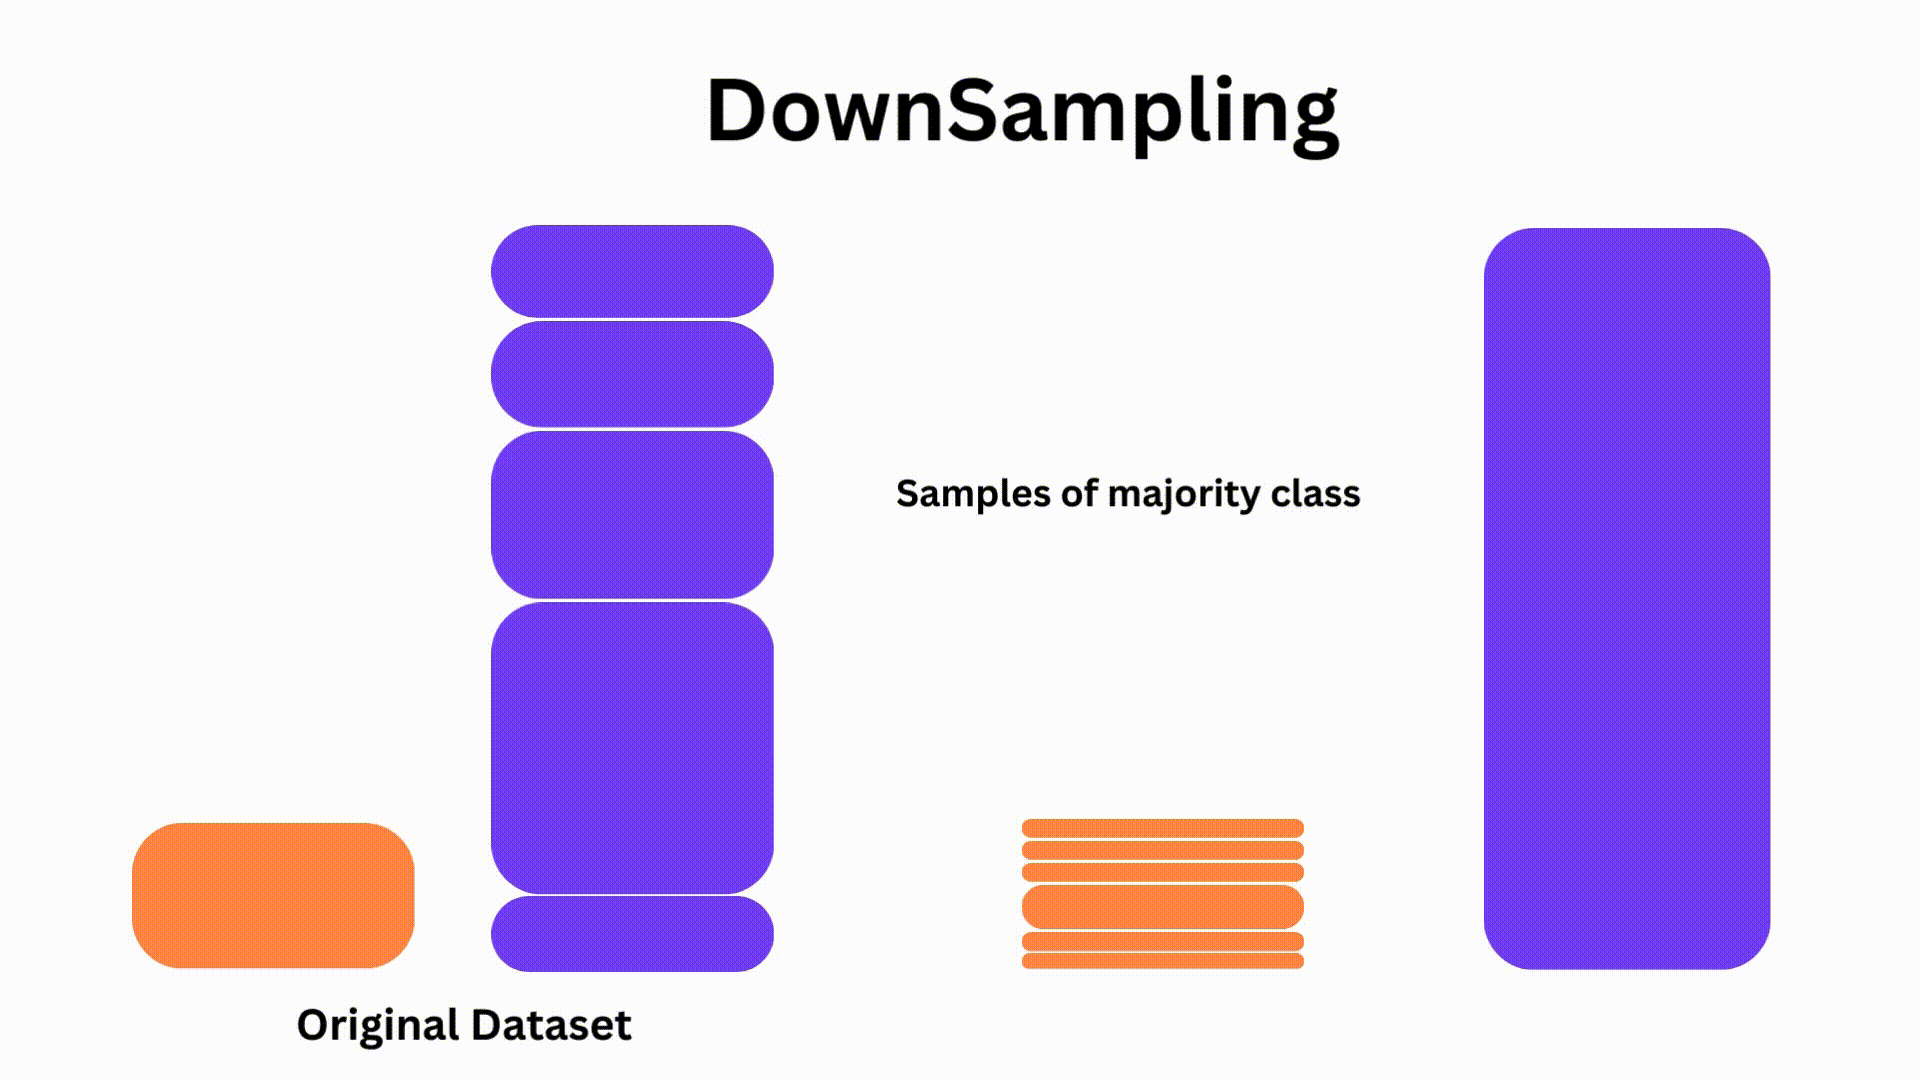

Reducerea dimensiunilor variate ale masuratorilor la o singura dimensiune (dimenisunea cea mai mica)

Metoda folosita: **Decimation**

Pentru ficare masuratoare, se va selecta din ***offset*** in ***offset*** valorile pentru dataframe-ul final, unde
***offset***=$
\frac{\text{frecventa cu care a fost masurata valoarea}}{\text{frecventa cea mai mica}}
$

In [9]:
acc_sampling_factor = 32 // 4
bvp_sampling_factor = 64 // 4
eda_sampling_factor = 4 // 4
temp_sampling_factor = 4 // 4
labels_sampling_factor = 700 // 4

tabel_lenght = len(temp_df)

downsampled_acc = acc_df[::acc_sampling_factor][:tabel_lenght]
downsampled_bvp = bvp_df[::bvp_sampling_factor][:tabel_lenght]
downsampled_eda = eda_df[::eda_sampling_factor][:tabel_lenght]
downsampled_temp = temp_df[::temp_sampling_factor][:tabel_lenght]
downsampled_labels = labels[::labels_sampling_factor][:tabel_lenght]
downsampled_labels_series = pd.Series(downsampled_labels, name='label')

combined_df = pd.concat([downsampled_acc.reset_index(drop=True),
                         downsampled_bvp.reset_index(drop=True),
                         downsampled_eda.reset_index(drop=True),
                         downsampled_temp.reset_index(drop=True),
                         downsampled_labels_series.reset_index(drop=True)],
                        axis=1)

combined_df.columns = ['acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp', 'label']

print(combined_df)

       acc_x  acc_y  acc_z     bvp       eda   temp  label
0       62.0  -21.0  107.0  -59.37  1.138257  35.41      0
1       51.0   16.0   35.0   43.50  1.125444  35.41      0
2       53.0   21.0   -6.0   53.56  1.011405  35.41      0
3       55.0   17.0   34.0   54.64  1.033188  35.41      0
4       48.0   24.0   15.0 -117.88  0.935807  35.41      0
...      ...    ...    ...     ...       ...    ...    ...
24311   47.0   14.0   41.0   27.06  0.063052  34.21      0
24312   46.0   15.0   40.0   14.01  0.060489  34.23      0
24313   49.0   15.0   41.0   -0.43  0.059208  34.23      0
24314   46.0   17.0   36.0  -32.72  0.073303  34.23      0
24315   56.0   23.0   38.0   15.20  0.045113  34.23      0

[24316 rows x 7 columns]


Selectam acele linii care au label-ul egal cu 1 sau cu 2 ( **1** = **baseline**, **2** = **stress** )

In [10]:
filtered_df = combined_df[(combined_df.label == 1) | (combined_df.label == 2)]
print(filtered_df)

       acc_x  acc_y  acc_z    bvp       eda   temp  label
1227    65.0   12.0   21.0 -33.58  1.640539  35.81      1
1228    55.0  -32.0   44.0  30.52  1.634132  35.81      1
1229    49.0  -21.0   30.0  52.54  1.614912  35.81      1
1230    52.0  -22.0   27.0  94.31  1.591848  35.81      1
1231    58.0  -14.0   28.0 -38.86  1.558534  35.81      1
...      ...    ...    ...    ...       ...    ...    ...
11550   16.0  -59.0   14.0  -4.80  1.209913  32.61      2
11551   17.0  -59.0   15.0  -0.89  1.206069  32.61      2
11552   16.0  -59.0   15.0   7.84  1.206069  32.59      2
11553   16.0  -59.0   15.0   9.49  1.199662  32.59      2
11554   14.0  -58.0   14.0 -31.63  1.191974  32.59      2

[7036 rows x 7 columns]


In [11]:
filtered_df['label'] = filtered_df['label'].replace({1: 'baseline', 2: 'stress'})

filtered_df

C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_10380\3165240037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].replace({1: 'baseline', 2: 'stress'})


,acc_x,acc_y,acc_z,bvp,eda,temp,label
1227,65.0,12.0,21.0,-33.58,1.640539,35.81,baseline
1228,55.0,-32.0,44.0,30.52,1.634132,35.81,baseline
1229,49.0,-21.0,30.0,52.54,1.614912,35.81,baseline
1230,52.0,-22.0,27.0,94.31,1.591848,35.81,baseline
1231,58.0,-14.0,28.0,-38.86,1.558534,35.81,baseline
...,...,...,...,...,...,...,...
11550,16.0,-59.0,14.0,-4.80,1.209913,32.61,stress
11551,17.0,-59.0,15.0,-0.89,1.206069,32.61,stress
11552,16.0,-59.0,15.0,7.84,1.206069,32.59,stress
11553,16.0,-59.0,15.0,9.49,1.199662,32.59,stress


In [12]:
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,acc_x,acc_y,acc_z,bvp,eda,temp,label
0,65.0,12.0,21.0,-33.58,1.640539,35.81,baseline
1,55.0,-32.0,44.0,30.52,1.634132,35.81,baseline
2,49.0,-21.0,30.0,52.54,1.614912,35.81,baseline
3,52.0,-22.0,27.0,94.31,1.591848,35.81,baseline
4,58.0,-14.0,28.0,-38.86,1.558534,35.81,baseline
...,...,...,...,...,...,...,...
7031,16.0,-59.0,14.0,-4.80,1.209913,32.61,stress
7032,17.0,-59.0,15.0,-0.89,1.206069,32.61,stress
7033,16.0,-59.0,15.0,7.84,1.206069,32.59,stress
7034,16.0,-59.0,15.0,9.49,1.199662,32.59,stress


In [13]:
def read_data(pickleFileName):
  with open(pickleFileName, 'rb') as file:
    data = pickle.load(file, encoding='latin1')
  return data

def downsampleDataSet(dataset):
  wrist_data = data['signal']['wrist']
  acc_df = pd.DataFrame(wrist_data['ACC'], columns=['ACC_X', 'ACC_Y', 'ACC_Z'])
  bvp_df = pd.DataFrame(wrist_data['BVP'], columns=['BVP'])
  eda_df = pd.DataFrame(wrist_data['EDA'], columns=['EDA'])
  temp_df = pd.DataFrame(wrist_data['TEMP'], columns=['TEMP'])
  labels = data['label']

  acc_sampling_factor = 32 // 4
  bvp_sampling_factor = 64 // 4
  eda_sampling_factor = 4 // 4
  temp_sampling_factor = 4 // 4
  labels_sampling_factor = 700 // 4

  tabel_lenght = len(temp_df)

  downsampled_acc = acc_df[::acc_sampling_factor][:tabel_lenght]
  downsampled_bvp = bvp_df[::bvp_sampling_factor][:tabel_lenght]
  downsampled_eda = eda_df[::eda_sampling_factor][:tabel_lenght]
  downsampled_temp = temp_df[::temp_sampling_factor][:tabel_lenght]
  downsampled_labels = labels[::labels_sampling_factor][:tabel_lenght]
  downsampled_labels_series = pd.Series(downsampled_labels, name='label')

  combined_df = pd.concat([downsampled_acc.reset_index(drop=True),
                          downsampled_bvp.reset_index(drop=True),
                          downsampled_eda.reset_index(drop=True),
                          downsampled_temp.reset_index(drop=True),
                          downsampled_labels_series.reset_index(drop=True)],
                          axis=1)

  combined_df.columns = ['acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp', 'label']
  filtered_df = combined_df[(combined_df.label == 1) | (combined_df.label == 2)].copy()

  # Replace the label values
  filtered_df['label'] = filtered_df['label'].replace({1: 'baseline', 2: 'stress'})

  # Reset the index
  filtered_df = filtered_df.reset_index(drop=True)

  return filtered_df

In [14]:
def getDataSet(pickleFileName):
  dataset = read_data(pickleFileName)
  dataset = downsampleDataSet(dataset)
  return dataset


## Vizualizarea datelor

In [20]:
datasetS2 = getDataSet('WESAD/S2.pkl')

In [21]:

def plotMeasurement(dataset, measurement):
  plt.figure(figsize=(12, 6))
  plt.plot(dataset[measurement])
  plt.xlabel('Index')
  plt.ylabel(measurement)
  plt.title(f'{measurement} Variation')

  max_measurement = dataset[measurement].max()
  min_measurement = dataset[measurement].min()
  for i in range(len(dataset)):
    if dataset['label'].iloc[i] == 'baseline':
      plt.bar(i, max_measurement - min_measurement, bottom=min_measurement, color='green', width=1, alpha=0.3)
    elif dataset['label'].iloc[i] == 'stress':
      plt.bar(i, max_measurement - min_measurement,bottom=min_measurement, color='red', width=1, alpha=0.3)

  plt.show()

### ACC X

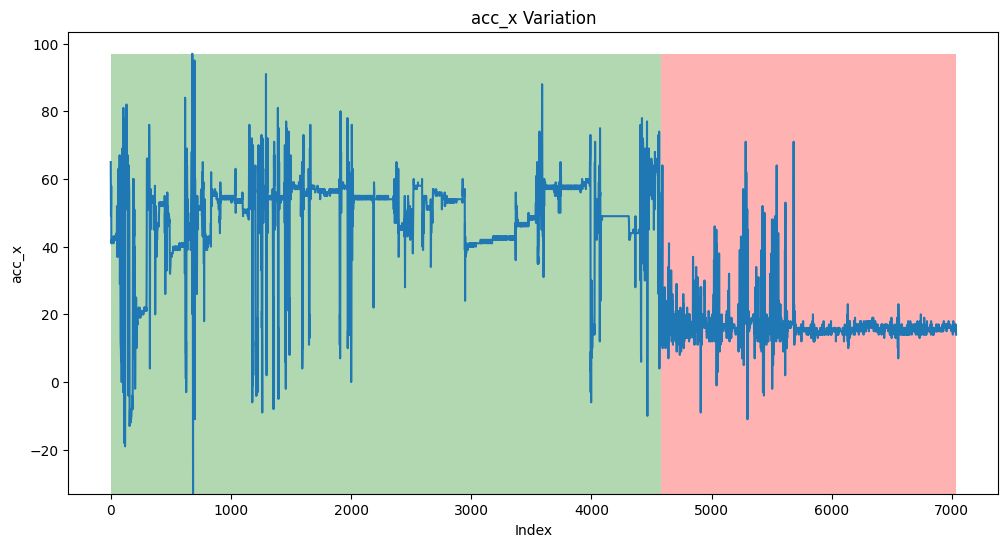

In [ ]:
plotMeasurement(datasetS2, 'acc_x')

### ACC Y

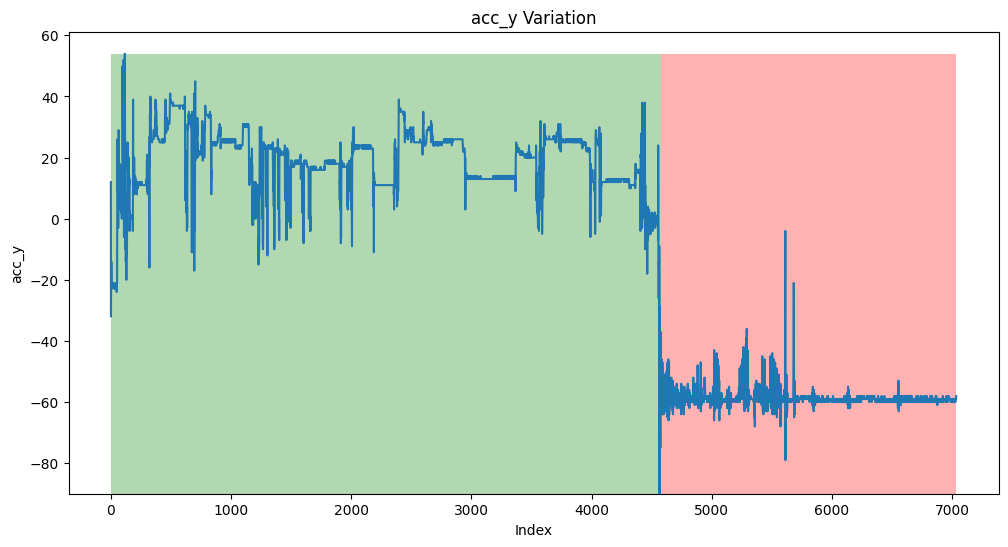

In [ ]:
plotMeasurement(datasetS2, 'acc_y')

### ACC Z

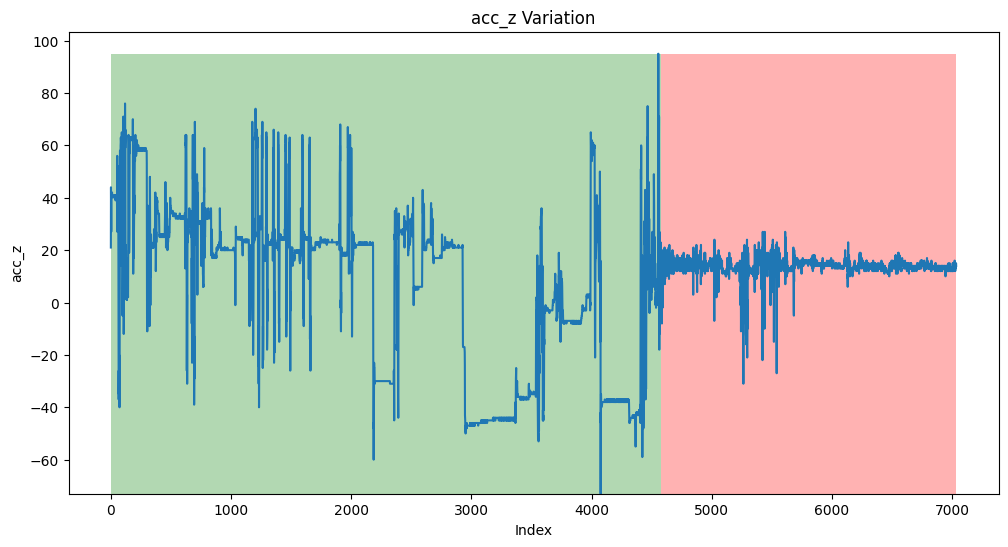

In [ ]:
plotMeasurement(datasetS2, 'acc_z')

### BVP

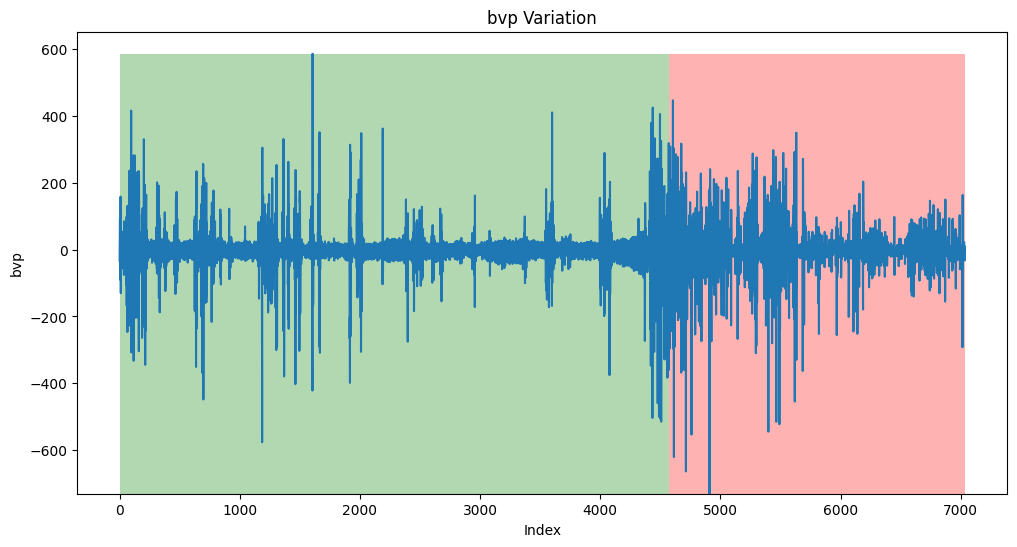

In [ ]:
plotMeasurement(datasetS2, 'bvp')

### EDA

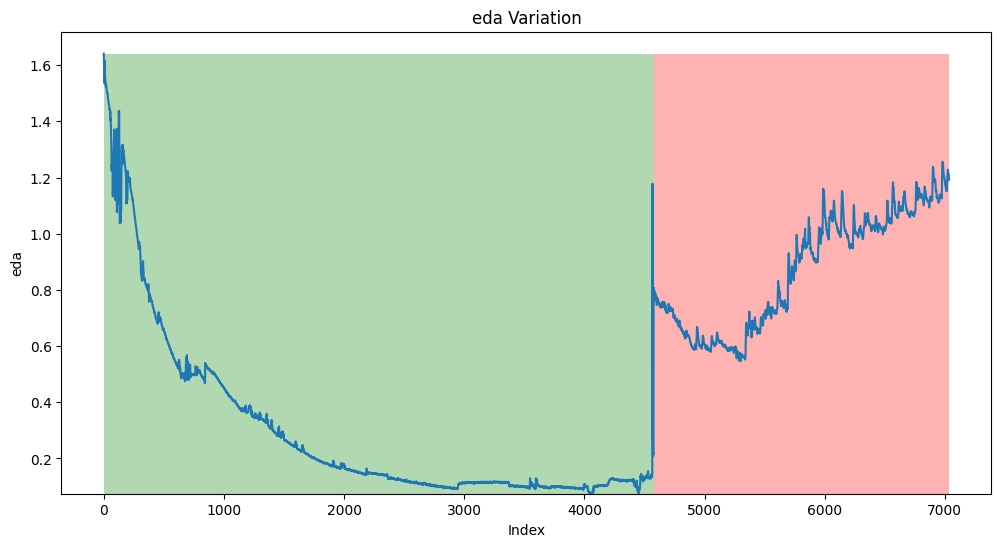

In [ ]:
plotMeasurement(datasetS2, 'eda')

### TEMP

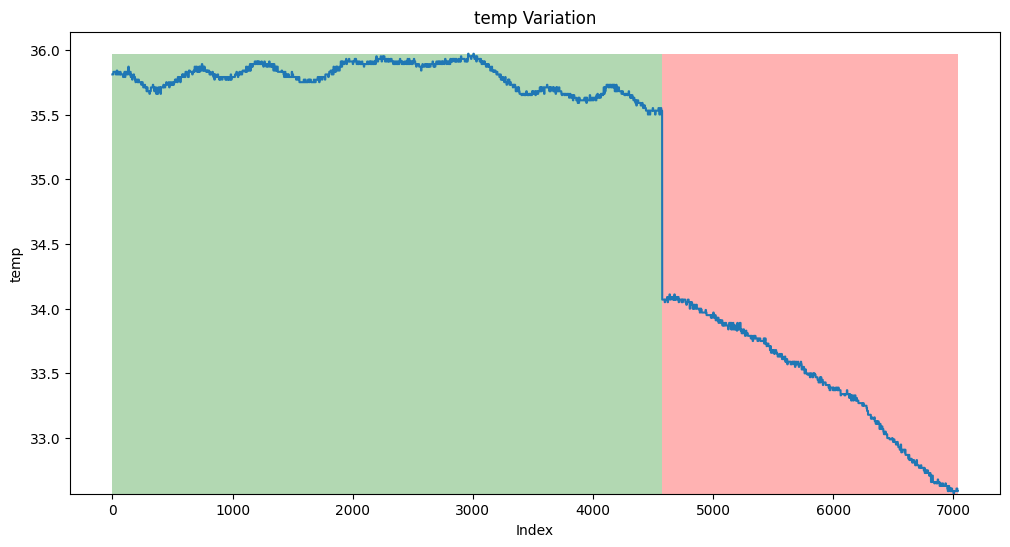

In [ ]:
plotMeasurement(datasetS2, 'temp')

## Normalizare

In [22]:
for column_name, column_type in zip(filtered_df.columns, filtered_df.dtypes):
    if column_type == 'float64' or column_type == 'int64':
        # filtered_df[column_name] = (filtered_df[column_name] - filtered_df[column_name].mean()) / filtered_df[column_name].std()
        filtered_df[column_name] = (filtered_df[column_name] - filtered_df[column_name].min()) / (filtered_df[column_name].max() - filtered_df[column_name].min())

filtered_df

,acc_x,acc_y,acc_z,bvp,eda,temp,label
0,0.753846,0.708333,0.559524,0.529267,1.000000,0.952941,baseline
1,0.676923,0.402778,0.696429,0.577893,0.995909,0.952941,baseline
2,0.630769,0.479167,0.613095,0.594597,0.983635,0.952941,baseline
3,0.653846,0.472222,0.595238,0.626284,0.968907,0.952941,baseline
4,0.700000,0.527778,0.601190,0.525261,0.947633,0.952941,baseline
...,...,...,...,...,...,...,...
7031,0.376923,0.215278,0.517857,0.551099,0.725007,0.011765,stress
7032,0.384615,0.215278,0.523810,0.554065,0.722553,0.011765,stress
7033,0.376923,0.215278,0.523810,0.560688,0.722553,0.005882,stress
7034,0.376923,0.215278,0.523810,0.561940,0.718461,0.005882,stress


In [15]:
def normalizeaza_date(dataset):
  for column_name, column_type in zip(filtered_df.columns, filtered_df.dtypes):
    if column_type == 'float64' or column_type == 'int64':
        dataset[column_name] = (dataset[column_name] - dataset[column_name].min()) / (dataset[column_name].max() - dataset[column_name].min())
  return dataset

### Creare functii de verificare a randamentului modelului

In [16]:
def getAccuracy(TN, FP, FN, TP):
    """
    accuracy represents the overall performance of classification model:
    (TP+TN)/(TN+FP+FN+TP)
    """
    if (TN+FP+FN+TP) == 0:
        return 0
    return (TP+TN)/(TN+FP+FN+TP)

def getPrecision(FP, TP):
    """
    precision indicates how accurate the positive predictions are
    TP/(TP+FP)
    """
    if (TP+FP) == 0:
        return 0
    return TP/(TP+FP)

def getRecall(TP, FN):
    """
    recall indicates the coverage of actual positive sample
    TP/(TP+FN)
    """
    if (TP+FN) == 0:
        return 0
    return TP/(TP+FN)

def clasificationPerformance(ground_truth, computed_values, positive_label = "stress"):
    """
    Returneaza TN (True Negative), FP(False Positive), FN(False Negative), TP(True Positive)
    """
    TN = 0
    FP = 0
    FN = 0
    TP = 0

    for i in range(0, len(ground_truth)):
        if ground_truth.iloc[i] == positive_label:
            if computed_values.iloc[i] == positive_label:
                TP += 1
            else:
                FP += 1
        else:
            if computed_values.iloc[i] != positive_label:
                TN += 1
            else:
                FN += 1
    return TN, FP, FN, TP

def test_classificator_qualitty(ground_truth, computed_values, positive_label='stress'):
    TN, FP, FN, TP = clasificationPerformance(ground_truth,computed_values,positive_label)
    accuracy = getAccuracy(TN,FP,FN,TP)
    precision = getPrecision(FP,TP)
    recall = getRecall(TP,FN)
    print("\nAccuracy: {}\nPrecision: {}\nRecall: {}".format(accuracy,precision,recall))

## Impartire in date de antrenament si test

In [17]:
def getTrainingAndTestData(df, test_size):
  np.random.seed(70)
  shuffled_indices = np.random.permutation(len(df))
  test_set_size = int(len(df) * test_size)
  indexes = [i for i in range(len(df))]
  test_indices = np.random.choice(indexes, test_set_size, replace = False)
  train_indices = [i for i in indexes if i not in test_indices]
  train_set = df.iloc[train_indices]
  test_set = df.iloc[test_indices]
  return train_set, test_set


In [26]:
train_set, test_set = getTrainingAndTestData(filtered_df, 0.3)

print("Train Set")
print(train_set)
print("Test Set")
print(test_set)

Train Set
         acc_x     acc_y     acc_z       bvp       eda      temp     label
0     0.753846  0.708333  0.559524  0.529267  1.000000  0.952941  baseline
1     0.676923  0.402778  0.696429  0.577893  0.995909  0.952941  baseline
2     0.630769  0.479167  0.613095  0.594597  0.983635  0.952941  baseline
4     0.700000  0.527778  0.601190  0.525261  0.947633  0.952941  baseline
5     0.576923  0.506944  0.684524  0.486603  0.949269  0.952941  baseline
...        ...       ...       ...       ...       ...       ...       ...
7029  0.376923  0.215278  0.517857  0.557434  0.729098  0.011765    stress
7031  0.376923  0.215278  0.517857  0.551099  0.725007  0.011765    stress
7032  0.384615  0.215278  0.523810  0.554065  0.722553  0.011765    stress
7033  0.376923  0.215278  0.523810  0.560688  0.722553  0.005882    stress
7034  0.376923  0.215278  0.523810  0.561940  0.718461  0.005882    stress

[4926 rows x 7 columns]
Test Set
         acc_x     acc_y     acc_z       bvp       eda  

# **Model Inteligent**

## Formarea modelului

In [18]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

def get_model(length_of_consecutive_timeline, number_of_features=1, number_of_neurons_in_ann=5):
    input_acc_x = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_acc_x')
    input_acc_y = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_acc_y')
    input_acc_z = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_acc_z')
    input_bvp = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_bvp')
    input_eda = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_eda')
    input_temp = Input(shape=(length_of_consecutive_timeline, number_of_features), name='input_temp')

    lstm_acc_x = LSTM(length_of_consecutive_timeline, activation='relu')(input_acc_x)
    # lstm_acc_x = Dropout(0.2)(lstm_acc_x)
    lstm_acc_y = LSTM(length_of_consecutive_timeline, activation='relu')(input_acc_y)
    # lstm_acc_y = Dropout(0.2)(lstm_acc_y)
    lstm_acc_z = LSTM(length_of_consecutive_timeline, activation='relu')(input_acc_z)
    # lstm_acc_z = Dropout(0.2)(lstm_acc_z)
    lstm_bvp = LSTM(length_of_consecutive_timeline, activation='relu')(input_bvp)
    # lstm_bvp = Dropout(0.2)(lstm_bvp)
    lstm_eda = LSTM(length_of_consecutive_timeline, activation='relu')(input_eda)
    # lstm_eda = Dropout(0.2)(lstm_eda)
    lstm_temp = LSTM(length_of_consecutive_timeline, activation='relu')(input_temp)
    # lstm_temp = Dropout(0.2)(lstm_temp)

    fusion = Concatenate()([lstm_acc_x, lstm_acc_y, lstm_acc_z, lstm_bvp, lstm_eda, lstm_temp])

    dense_1 = Dense(number_of_neurons_in_ann, activation='relu')(fusion)
    output = Dense(1, activation='sigmoid')(dense_1)

    model = Model(inputs=[input_acc_x, input_acc_y, input_acc_z, input_bvp, input_eda, input_temp], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



## Antrenarea modelului

In [ ]:
import time

start_time = time.time()

model.fit([train_set['acc_x'],train_set['acc_y'],train_set['acc_z'], train_set['bvp'], train_set['eda'], train_set['temp']], train_set['label'].replace({'baseline': 0, 'stress': 1}), epochs=3)


end_time = time.time()

training_time = end_time - start_time

print(f"Model trained in : {training_time} seconds")

Epoch 1/3


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_4668\2710610873.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model.fit([train_set['acc_x'],train_set['acc_y'],train_set['acc_z'], train_set['bvp'], train_set['eda'], train_set['temp']], train_set['label'].replace({'baseline': 0, 'stress': 1}), epochs=3)
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.3155
Epoch 2/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2277
Epoch 3/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2310
Model trained in : 13.33516550064087 seconds


In [ ]:
predictions = model.predict([test_set['acc_x'],test_set['acc_y'],test_set['acc_z'], test_set['bvp'], test_set['eda'], test_set['temp']])

predicted_classes = (predictions > 0.5).astype(int)

results = pd.DataFrame({
    'Actual': test_set['label'],
    'Predicted': predicted_classes.flatten()
})

results.replace({0: 'baseline', 1: 'stress'}, inplace=True)

results

c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


,Actual,Predicted
269,baseline,baseline
4815,stress,baseline
1438,baseline,baseline
1520,baseline,baseline
4195,baseline,baseline
...,...,...
1800,baseline,baseline
3264,baseline,baseline
95,baseline,baseline
2534,baseline,baseline


In [ ]:
equal_count = (results['Actual'] == results['Predicted']).sum()

print(equal_count,"/",len(results))

1359 / 2110


In [ ]:
TN, FP, FN, TP = clasificationPerformance(results['Actual'], results['Predicted'])
print("TN:",TN)
print("FP:",FP)
print("FN:",FN)
print("TP:",TP)

TN: 1359
FP: 751
FN: 0
TP: 0


#### Positive Label = stress

In [ ]:
test_classificator_qualitty(results['Actual'], results['Predicted'])


Accuracy: 0.6440758293838863
Precision: 0.0
Recall: 0


#### Positive label = baseline

In [ ]:
test_classificator_qualitty(results['Actual'], results['Predicted'], 'baseline')


Accuracy: 0.6440758293838863
Precision: 1.0
Recall: 0.6440758293838863


In [28]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, SimpleRNN
from tensorflow.keras.models import Model

def get_rnn_model(sequence_length, num_features=1, rnn_units=1, number_of_neurons_in_ann=24):
    input_acc_x = Input(shape=(sequence_length, num_features), name='input_acc_x')
    input_acc_y = Input(shape=(sequence_length, num_features), name='input_acc_y')
    input_acc_z = Input(shape=(sequence_length, num_features), name='input_acc_z')
    input_bvp = Input(shape=(sequence_length, num_features), name='input_bvp')
    input_eda = Input(shape=(sequence_length, num_features), name='input_eda')
    input_temp = Input(shape=(sequence_length, num_features), name='input_temp')

    rnn_acc_x = SimpleRNN(rnn_units, activation='relu')(input_acc_x)
    rnn_acc_y = SimpleRNN(rnn_units, activation='relu')(input_acc_y)
    rnn_acc_z = SimpleRNN(rnn_units, activation='relu')(input_acc_z)
    rnn_bvp = SimpleRNN(rnn_units, activation='relu')(input_bvp)
    rnn_eda = SimpleRNN(rnn_units, activation='relu')(input_eda)
    rnn_temp = SimpleRNN(rnn_units, activation='relu')(input_temp)

    fusion = Concatenate()([rnn_acc_x, rnn_acc_y, rnn_acc_z, rnn_bvp, rnn_eda, rnn_temp])

    dense_1 = Dense(number_of_neurons_in_ann, activation='relu')(fusion)
    output = Dense(1, activation='sigmoid')(dense_1)

    model = Model(inputs=[input_acc_x, input_acc_y, input_acc_z, input_bvp, input_eda, input_temp], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

sequence_length = 15
rnn_model = get_rnn_model(sequence_length=sequence_length, num_features=1, rnn_units=1, number_of_neurons_in_ann=15)
rnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 1)         │          3 │ input_acc_x[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 1)         │          3 │ input_acc_y[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 1)         │          3 │ input_acc_z[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, 1)         │          3 │ input_bvp[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_4        │ (None, 1)         │          3 │ input_eda[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, 1)         │          3 │ input_temp[0][0]  │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6)         │          0 │ simple_rnn[0][0], │
│ (Concatenate)       │                   │            │ simple_rnn_1[0][… │
│                     │                   │            │ simple_rnn_2[0][… │
│                     │                   │            │ simple_rnn_3[0][… │
│                     │                   │            │ simple_rnn_4[0][… │
│                     │                   │            │ simple_rnn_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 15)        │        105 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         16 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139 (556.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import time

start_time = time.time()

rnn_model.fit(
    [train_set['acc_x'],
     train_set['acc_y'],
     train_set['acc_z'],
     train_set['bvp'],
     train_set['eda'],
     train_set['temp']],
    train_set['label'].replace({'baseline': 0, 'stress': 1}),
    epochs=3
)

end_time = time.time()

training_time = end_time - start_time

print(f"Model trained in : {training_time} seconds")

Epoch 1/3


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_4668\1572721506.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_set['label'].replace({'baseline': 0, 'stress': 1}),
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5070 - loss: 0.2605
Epoch 2/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8516 - loss: 0.1233
Epoch 3/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9536 - loss: 0.0720
Model trained in : 8.106508016586304 seconds


In [ ]:
rnn_predictions = rnn_model.predict([test_set['acc_x'],test_set['acc_y'],test_set['acc_z'], test_set['bvp'], test_set['eda'], test_set['temp']])

rnn_predicted_classes = (rnn_predictions > 0.5).astype(int)

rnn_results = pd.DataFrame({
    'Actual': test_set['label'],
    'Predicted': rnn_predicted_classes.flatten()
})

rnn_results.replace({0: 'baseline', 1: 'stress'}, inplace=True)

rnn_results

c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


,Actual,Predicted
269,baseline,baseline
4815,stress,stress
1438,baseline,baseline
1520,baseline,baseline
4195,baseline,baseline
...,...,...
1800,baseline,baseline
3264,baseline,baseline
95,baseline,baseline
2534,baseline,baseline


In [ ]:
rnn_equal_count = (rnn_results['Actual'] == rnn_results['Predicted']).sum()

print(rnn_equal_count,"/",len(rnn_results))

2038 / 2110


#### Positive label = stress

In [ ]:
test_classificator_qualitty(rnn_results['Actual'], rnn_results['Predicted'])


Accuracy: 0.9658767772511848
Precision: 1.0
Recall: 0.9125151883353585


#### Positive label = baseline

In [ ]:
test_classificator_qualitty(rnn_results['Actual'], rnn_results['Predicted'], 'baseline')


Accuracy: 0.9658767772511848
Precision: 0.9470198675496688
Recall: 1.0


## Unirea fisierelor si antrenarea modelului pe setul de date complet

In [19]:
def getCombinedDataset(list_of_files):
  list_of_dataframes = []
  for file in list_of_files:
    dataset = getDataSet(file)
    list_of_dataframes.append(dataset)
  combined_df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)
  combined_df = normalizeaza_date(combined_df)
  return combined_df

In [ ]:
modelWithFullDataset = get_model(length_of_consecutive_timeline=15, number_of_features=1, number_of_neurons_in_ann=15)
modelWithFullDataset.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 1)         │         12 │ input_acc_x[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 1)         │         12 │ input_acc_y[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 1)         │         12 │ input_acc_z[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 1)         │         12 │ input_bvp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 1)         │         12 │ input_eda[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 1)         │         12 │ input_temp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 6)         │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ lstm_7[0][0],     │
│                     │                   │            │ lstm_8[0][0],     │
│                     │                   │            │ lstm_9[0][0],     │
│                     │                   │            │ lstm_10[0][0],    │
│                     │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 15)        │        105 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         16 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fullDataset = getCombinedDataset(['WESAD/S2.pkl', 'WESAD/S3.pkl'])
train_set, test_set = getTrainingAndTestData(fullDataset, 0.4)

import time

start_time = time.time()

modelWithFullDataset.fit([train_set['acc_x'],train_set['acc_y'],train_set['acc_z'], train_set['bvp'], train_set['eda'], train_set['temp']], train_set['label'].replace({'baseline': 0, 'stress': 1}), epochs=3)

end_time = time.time()

training_time = end_time - start_time

print(f"Model trained in : {training_time} seconds")

C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_4668\2007294394.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].replace({1: 'baseline', 2: 'stress'})
C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_4668\2007294394.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].replace({1: 'baseline', 2: 'stress'})
C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_4668\1237226645.py:8: FutureWarning: Downcasting be

Epoch 1/3


c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2696
Epoch 2/3
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1339
Epoch 3/3
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0947
Model trained in : 10.54664397239685 seconds


In [ ]:
predictions = modelWithFullDataset.predict([test_set['acc_x'],test_set['acc_y'],test_set['acc_z'], test_set['bvp'], test_set['eda'], test_set['temp']])

predicted_classes = (predictions > 0.5).astype(int)

results = pd.DataFrame({
    'Actual': test_set['label'],
    'Predicted': predicted_classes.flatten()
})

results.replace({0: 'baseline', 1: 'stress'}, inplace=True)

results

c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


,Actual,Predicted
7533,baseline,baseline
9829,baseline,baseline
6268,stress,stress
7304,baseline,stress
5414,stress,stress
...,...,...
3190,baseline,baseline
7416,baseline,stress
4135,baseline,baseline
5020,stress,baseline


In [ ]:
test_classificator_qualitty(results['Actual'], results['Predicted'])


Accuracy: 0.8866382373845061
Precision: 0.8783515392254221
Recall: 0.8182238667900092


## Testarea modelului cu toate fisierele

In [20]:
def reshape_data(data, timeline_length, features=1):
    """
    Reshape the flat data array into samples of timeline_length.
    """
    num_samples = len(data) // timeline_length
    return np.array(data[:num_samples * timeline_length]).reshape(num_samples, timeline_length, features)


In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
import pandas as pd

def testModel(dataset, testSize, length_of_consecutive_timeline, number_of_features, number_of_neurons_in_ann, nr_of_epochs):
    model = get_model(length_of_consecutive_timeline, number_of_features, number_of_neurons_in_ann)
    
    train_set, test_set = getTrainingAndTestData(dataset, testSize)
    print(train_set['label'].value_counts())
    print(test_set['label'].value_counts())

    model.summary()

    train_inputs = [
        reshape_data(train_set['acc_x'], length_of_consecutive_timeline),
        reshape_data(train_set['acc_y'], length_of_consecutive_timeline),
        reshape_data(train_set['acc_z'], length_of_consecutive_timeline),
        reshape_data(train_set['bvp'], length_of_consecutive_timeline),
        reshape_data(train_set['eda'], length_of_consecutive_timeline),
        reshape_data(train_set['temp'], length_of_consecutive_timeline)
    ]

    train_labels = train_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(train_inputs[0])] 

    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

    import time
    start_time = time.time()
    model.fit(train_inputs, train_labels, epochs=nr_of_epochs, class_weight=class_weight_dict)
    end_time = time.time()

    print(f"Model trained in : {end_time - start_time} seconds")

    test_inputs = [
        reshape_data(test_set['acc_x'], length_of_consecutive_timeline),
        reshape_data(test_set['acc_y'], length_of_consecutive_timeline),
        reshape_data(test_set['acc_z'], length_of_consecutive_timeline),
        reshape_data(test_set['bvp'], length_of_consecutive_timeline),
        reshape_data(test_set['eda'], length_of_consecutive_timeline),
        reshape_data(test_set['temp'], length_of_consecutive_timeline)
    ]

    test_labels = test_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(test_inputs[0])] 

    predictions = model.predict(test_inputs)

    predicted_classes = (predictions > 0.5).astype(int)

    results = pd.DataFrame({
        'Actual': test_labels,
        'Predicted': predicted_classes.flatten()
    })

    results.replace({0: 'baseline', 1: 'stress'}, inplace=True)

    print(results)

    test_classificator_qualitty(results['Actual'], results['Predicted'])

    model.save('my_model.keras')


In [22]:
indexes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
list_of_pkls = ['WESAD/S' + str(index) + '.pkl' for index in indexes]
dataset = getCombinedDataset(list_of_pkls)


Dataset: toti subjects

Numarul de consecutive timeline: 20

Numarul de neuroni: 60

Epoci: 10

In [63]:
testModel(dataset, 0.3,20,1,60,10)

label
baseline    47992
stress      25886
Name: count, dtype: int64
label
baseline    20648
stress      11014
Name: count, dtype: int64


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_90 (LSTM)      │ (None, 20)        │      1,760 │ input_acc_x[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_91 (LSTM)      │ (None, 20)        │      1,760 │ input_acc_y[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_92 (LSTM)      │ (None, 20)        │      1,760 │ input_acc_z[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_93 (LSTM)      │ (None, 20)        │      1,760 │ input_bvp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_94 (LSTM)      │ (None, 20)        │      1,760 │ input_eda[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_95 (LSTM)      │ (None, 20)        │      1,760 │ input_temp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 120)       │          0 │ lstm_90[0][0],    │
│ (Concatenate)       │                   │            │ lstm_91[0][0],    │
│                     │                   │            │ lstm_92[0][0],    │
│                     │                   │            │ lstm_93[0][0],    │
│                     │                   │            │ lstm_94[0][0],    │
│                     │                   │            │ lstm_95[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 60)        │      7,260 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │         61 │ dense_32[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,881 (69.85 KB)

 Trainable params: 17,881 (69.85 KB)

 Non-trainable params: 0 (0.00 B)

Shape of train_inputs: 6, (3693, 20, 1)
Length of train_labels: 3693
Class weights: {0: 0.5910691421254801, 1: 3.2451669595782073}
Epoch 1/10


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(train_inputs[0])]  # Convert to numpy array
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5237 - loss: 0.6973
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6153 - loss: 0.6948
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5108 - loss: 0.7048
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5997 - loss: 0.6877
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6298 - loss: 0.6823
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6175 - loss: 0.6863
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4447 - loss: 0.6902
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6166 - loss: 0.6974
Epoch 9/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6177 - loss: 0.6861
Epoch 10/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6200 - loss: 0.6974
Model trained in : 35.05873107910156 seconds


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = test_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(test_inputs[0])]


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
        Actual Predicted
0     baseline    stress
1       stress  baseline
2       stress    stress
3       stress  baseline
4     baseline  baseline
...        ...       ...
1578    stress  baseline
1579    stress    stress
1580    stress  baseline
1581  baseline  baseline
1582  baseline    stress

[1583 rows x 2 columns]

Accuracy: 0.5293746051800379
Precision: 0.4207650273224044
Recall: 0.35106382978723405


Dataset: toti subjects

Numarul de consecutive timeline: 20

Numarul de neuroni: 60

Epoci: 10

In [66]:
testModel(dataset, 0.3,15,1,145,15)

label
baseline    47992
stress      25886
Name: count, dtype: int64
label
baseline    20648
stress      11014
Name: count, dtype: int64


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_108 (LSTM)     │ (None, 15)        │      1,020 │ input_acc_x[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_109 (LSTM)     │ (None, 15)        │      1,020 │ input_acc_y[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_110 (LSTM)     │ (None, 15)        │      1,020 │ input_acc_z[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_111 (LSTM)     │ (None, 15)        │      1,020 │ input_bvp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_112 (LSTM)     │ (None, 15)        │      1,020 │ input_eda[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_113 (LSTM)     │ (None, 15)        │      1,020 │ input_temp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 90)        │          0 │ lstm_108[0][0],   │
│ (Concatenate)       │                   │            │ lstm_109[0][0],   │
│                     │                   │            │ lstm_110[0][0],   │
│                     │                   │            │ lstm_111[0][0],   │
│                     │                   │            │ lstm_112[0][0],   │
│                     │                   │            │ lstm_113[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 145)       │     13,195 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │        146 │ dense_38[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,461 (76.02 KB)

 Trainable params: 19,461 (76.02 KB)

 Non-trainable params: 0 (0.00 B)

Shape of train_inputs: 6, (4925, 15, 1)
Length of train_labels: 4925
Class weights: {0: 0.7676122194513716, 1: 1.4341875364006988}
Epoch 1/15


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(train_inputs[0])]  # Convert to numpy array
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5565 - loss: 0.6915
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5961 - loss: 0.6906
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4701 - loss: 0.6947
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4314 - loss: 0.7003
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5823 - loss: 0.6901
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4930 - loss: 0.6938
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3845 - loss: 0.6990
Epoch 8/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6178 - loss: 0.6930
Epoch 9/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6190 - loss: 0.6899
Epoch 10/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3743 - loss: 0.6962
Epoch 11/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5525 - loss: 0.6961
Epoch 12/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/st

C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = test_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(test_inputs[0])]


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
        Actual Predicted
0     baseline    stress
1       stress    stress
2       stress    stress
3       stress  baseline
4     baseline    stress
...        ...       ...
2105  baseline    stress
2106  baseline    stress
2107  baseline    stress
2108    stress    stress
2109  baseline    stress

[2110 rows x 2 columns]

Accuracy: 0.33838862559241706
Precision: 0.997179125528914
Recall: 0.3365064255116611


Dataset: toti subjects

Numarul de consecutive timeline: 15

Numarul de neuroni: 80

Epoci: 50

In [24]:
testModel(dataset, 0.3,15,1,65,50)

label
baseline    47992
stress      25886
Name: count, dtype: int64
label
baseline    20648
stress      11014
Name: count, dtype: int64


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 15)        │      1,020 │ input_acc_x[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 15)        │      1,020 │ input_acc_y[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 15)        │      1,020 │ input_acc_z[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 15)        │      1,020 │ input_bvp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 15)        │      1,020 │ input_eda[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 15)        │      1,020 │ input_temp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 90)        │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ lstm_7[0][0],     │
│                     │                   │            │ lstm_8[0][0],     │
│                     │                   │            │ lstm_9[0][0],     │
│                     │                   │            │ lstm_10[0][0],    │
│                     │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 65)        │      5,915 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         66 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_10380\1395992318.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(train_inputs[0])]
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.4928 - loss: 0.6947
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4875 - loss: 0.6948
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5244 - loss: 0.6931
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4818 - loss: 0.6938
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5091 - loss: 0.6940
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5851 - loss: 0.6873
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4843 - loss: 0.6940
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4697 - loss: 0.6951
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6254 - loss: 0.6899
Epoch 10/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3955 - loss: 0.6962
Epoch 11/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4713 - loss: 0.6955
Epoch 12/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/st

C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_10380\1395992318.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = test_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(test_inputs[0])]


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step
        Actual Predicted
0     baseline    stress
1       stress    stress
2       stress    stress
3       stress  baseline
4     baseline    stress
...        ...       ...
2105  baseline  baseline
2106  baseline    stress
2107  baseline    stress
2108    stress    stress
2109  baseline    stress

[2110 rows x 2 columns]

Accuracy: 0.42274881516587676
Precision: 0.7306064880112835
Recall: 0.3352750809061489


Dataset: toti subjects

Numarul de consecutive timeline: 20

Numarul de neuroni: 160

Epoci: 100

In [68]:
testModel(dataset, 0.3,20,1,160,100)

label
baseline    47992
stress      25886
Name: count, dtype: int64
label
baseline    20648
stress      11014
Name: count, dtype: int64


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_acc_x         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_y         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_acc_z         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_bvp           │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eda           │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temp          │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_120 (LSTM)     │ (None, 20)        │      1,760 │ input_acc_x[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_121 (LSTM)     │ (None, 20)        │      1,760 │ input_acc_y[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_122 (LSTM)     │ (None, 20)        │      1,760 │ input_acc_z[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_123 (LSTM)     │ (None, 20)        │      1,760 │ input_bvp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_124 (LSTM)     │ (None, 20)        │      1,760 │ input_eda[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_125 (LSTM)     │ (None, 20)        │      1,760 │ input_temp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 120)       │          0 │ lstm_120[0][0],   │
│ (Concatenate)       │                   │            │ lstm_121[0][0],   │
│                     │                   │            │ lstm_122[0][0],   │
│                     │                   │            │ lstm_123[0][0],   │
│                     │                   │            │ lstm_124[0][0],   │
│                     │                   │            │ lstm_125[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 160)       │     19,360 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │        161 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,081 (117.50 KB)

 Trainable params: 30,081 (117.50 KB)

 Non-trainable params: 0 (0.00 B)

Shape of train_inputs: 6, (3693, 20, 1)
Length of train_labels: 3693
Class weights: {0: 0.5910691421254801, 1: 3.2451669595782073}
Epoch 1/100


C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(train_inputs[0])]  # Convert to numpy array
c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_acc_x', 'input_acc_y', 'input_acc_z', 'input_bvp', 'input_eda', 'input_temp']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6363 - loss: 0.6849
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6065 - loss: 0.6931
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5975 - loss: 0.6931
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5970 - loss: 0.6872
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6261 - loss: 0.6851
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5871 - loss: 0.7048
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5387 - loss: 0.7112
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5918 - loss: 0.7102
Epoch 9/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6166 - loss: 0.6923
Epoch 10/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6265 - loss: 0.6799
Epoch 11/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6197 - loss: 0.6686
Epoch 12/100
116/116 ━━━━━━━━━━━━━━━━━━━━

C:\Users\Irimieş Vasile\AppData\Local\Temp\ipykernel_18884\2136188881.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = test_set['label'].replace({'baseline': 0, 'stress': 1}).values[:len(test_inputs[0])]


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
        Actual Predicted
0     baseline  baseline
1       stress  baseline
2       stress    stress
3       stress  baseline
4     baseline    stress
...        ...       ...
1578    stress  baseline
1579    stress    stress
1580    stress  baseline
1581  baseline  baseline
1582  baseline  baseline

[1583 rows x 2 columns]

Accuracy: 0.5818066961465572
Precision: 0.2459016393442623
Recall: 0.3524804177545692
